# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    %autoreload 2
    %matplotlib inline
    extensions_loaded = True

%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import so_ml_tools as soml
import tensorflow as tf
import sklearn as sk
import keras as ks
import pandas as pd
import numpy as np
import seaborn as sns
import shap as sh
import sweetviz as sv

from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras import layers

2024-02-12 20:59:56.174525: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 20:59:56.174546: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 20:59:56.174566: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we can download the data from coinddesk if needed.

In [3]:
soml.util.io.download_file(source='https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 
                           filepath='./data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', overwrite=False)
soml.util.io.list_dir_summary(folder='./data')

Download of https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv skipped, file ./data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv exists.
There are 1 directories, and 1 in ./data
There are 0 directories, and 1 in ./data/.ipynb_checkpoints


In [4]:
## Importing time series with pandas
df = pd.read_csv('./data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 
                 parse_dates=['Date'], # Specify columns that contain date information.
                 index_col=['Date']) # Specify the column that is used for indexing
df.head(n=10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266


In [5]:
df.tail(n=10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-09,BTC,58788.209679,57419.147888,59575.463115,57028.498049
2021-05-10,BTC,58102.191426,58966.915010,59249.141676,56494.915334
2021-05-11,BTC,55715.546651,58308.318048,59560.025459,53774.628243
2021-05-12,BTC,56573.555472,55899.752971,56956.075029,54571.693210
2021-05-13,BTC,52147.821187,56767.711063,58036.509777,51625.547849
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [7]:
# How many samples do we have vs how many samples should we have.
len(df), 8*365, 8*365-len(df)

(2787, 2920, 133)

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can be thousands to tens of thousands to millions).

A smaller number of samples is somethign you'll often run into with time series data problems.

In [8]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


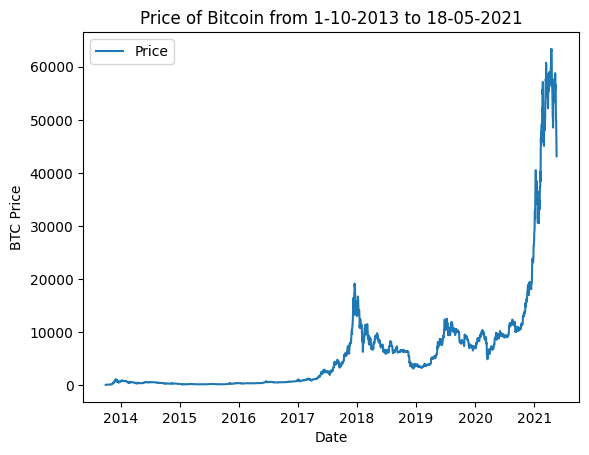

In [9]:
sns.lineplot(data=bitcoin_prices)
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.title('Price of Bitcoin from 1-10-2013 to 18-05-2021')
plt.show()

In [10]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open(file='./data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
    csv_reader = csv.reader(f, delimiter=',')
    next(csv_reader) # Skip header
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], '%Y-%m-%d'))
        btc_price.append(float(line[2]))

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

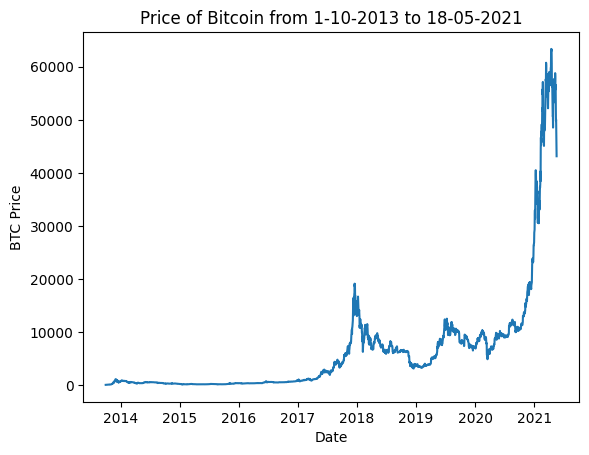

In [11]:
sns.lineplot(x=timesteps, y=btc_price)
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.title('Price of Bitcoin from 1-10-2013 to 18-05-2021')
plt.show()

# Format Data Part 1: Create train and test sets of our time series data.

## Creating train & tests with time series data (the wrong way)

In [12]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [13]:
# Wrong way to make train/test sets for time series data
X_train, X_test, y_train, y_test = soml.data.split.split_train_test_data(timesteps, prices, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

In [14]:
X_train[:10]

array(['2015-05-23T00:00:00.000000000', '2017-11-27T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2014-01-09T00:00:00.000000000',
       '2014-08-12T00:00:00.000000000', '2019-11-26T00:00:00.000000000',
       '2015-11-28T00:00:00.000000000', '2015-12-27T00:00:00.000000000',
       '2018-04-10T00:00:00.000000000', '2014-06-19T00:00:00.000000000'],
      dtype='datetime64[ns]')

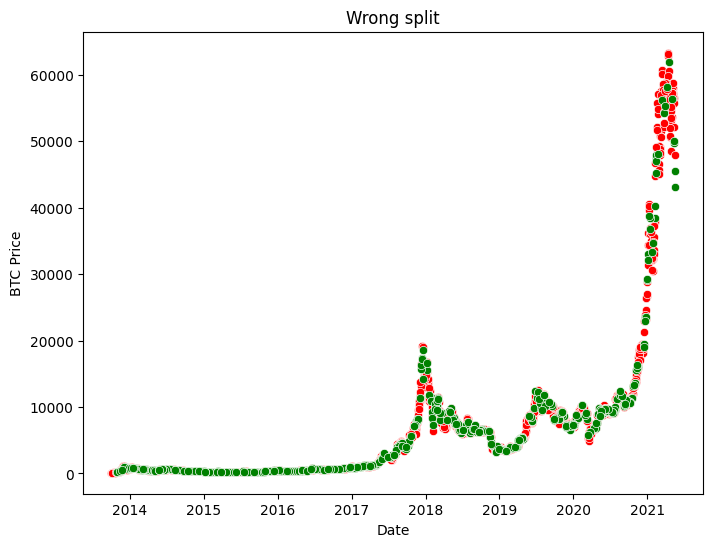

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x=X_train, y=y_train, color='red', ax=ax)
sns.scatterplot(x=X_test, y=y_test, color='green', ax=ax)
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.title('Wrong split')

fig.patch.set_alpha(0.0)  # Transparant background

label_color = 'black'
ax.xaxis.label.set_color(label_color)  # Set color of x-axis label
ax.tick_params(axis='x', colors=label_color)  # Set color of x-axis ticks.

ax.yaxis.label.set_color(label_color)  # Set color of y-axis label
ax.tick_params(axis='y', colors=label_color)  # Set color of y-axis ticks.
ax.title.set_color(label_color)  # Set color of title

plt.show()

In [16]:
X_train, X_test = soml.data.split.split_train_test_data(bitcoin_prices, shuffle=False)

In [17]:
# Right way to make train/test sets for time series data
X_train, X_test, y_train, y_test = soml.data.split.split_train_test_data(timesteps, prices, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

## Create train & test sets for time series (the right way)

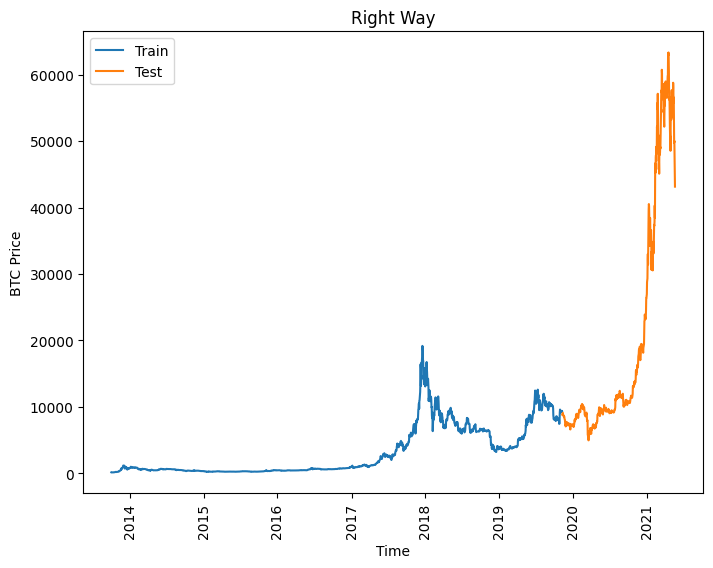

In [18]:
soml.data.timeseries.plot.timeseries(x=[X_train, X_test], y=[y_train, y_test], labels=['Train', 'Test'], title='Right Way', x_label='Time', y_label='BTC Price', start=1)

# Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* Horizon = number of timesteps into the future we're going to predict.
* Window size = number of timesteps we're going to use to predict horizon.

Modelling experiments we're running:
* 0	Naïve model (baseline)
* 1	Dense model	horizon = 1, window = 7
* 2	Same as 1, horizon = 1, window = 30
* 3	Same as 1, horizon = 7, window = 30
* 4	Conv1D, horizon = 1, window = 7
* 5	LSTM, horizon = 1, window = 7
* 6	Same as 1 (but with multivariate data), horizon = 1, window = 7, additional data = Block reward size
* 7	N-BEATs Algorithm, horizon = 1, window = 7
* 8	Ensemble (multiple models optimized on different loss functions), horizon = 1, window = 7
* 9	Future prediction model (model to predict future values), horizon = 1, window = 7
* 10 Same as 1 (but with turkey 🦃 data introduced), horizon = 1, window = 7

## Model 0: Naive model (Baseline)

The formula looks like this: $\hat{y}_t = y_{t-1}$

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [19]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

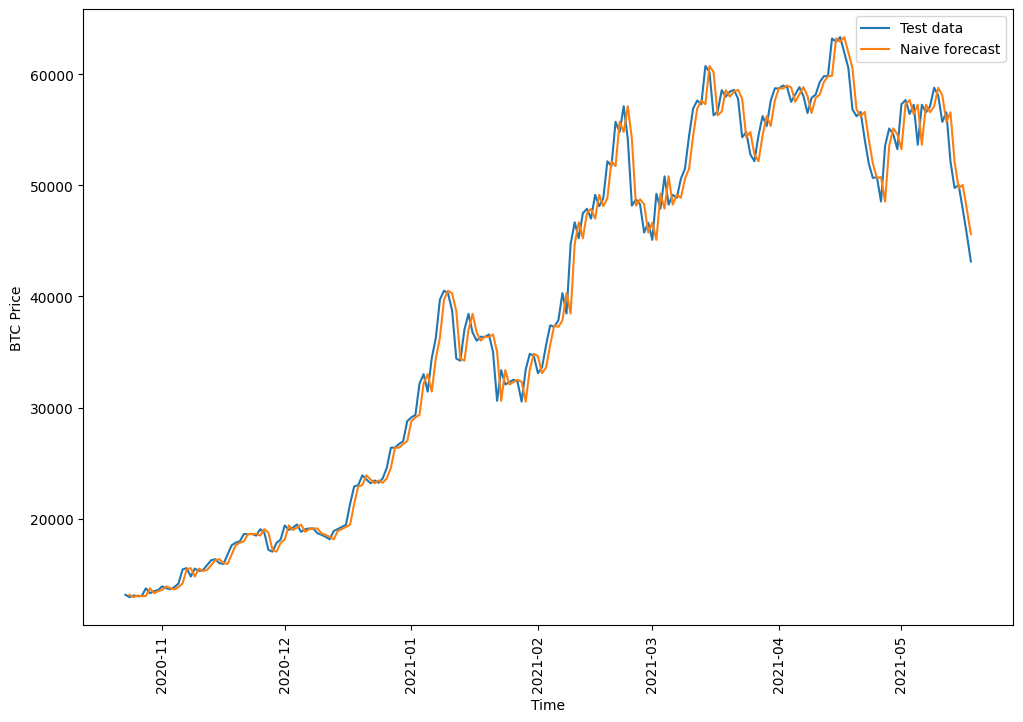

In [20]:
soml.data.timeseries.plot.timeseries(x=[X_test, X_test[1:]], y=[y_test, naive_forecast], labels=['Test data', 'Naive forecast'], x_label='Time', y_label='BTC Price', start=350, figsize=(12,8))

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of regression problem.

Because we're working on a regressio nproblem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean absolute error
* MSE - Mean squared error
* RMSE - Root mean squared error
* MAPE/sMape - (symmetric) mean absolute percentage error
* MASE - Mean absolute scaled error

For all of the above metrics, **lower is better**, for example, MAE of 0is better than an MAE of 100.

The main thing we're evaluating here is: how do our model´s forecasts $\hat{y}$ compare against the actual value y? 


In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    
    return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast)

2024-02-12 20:59:58.720187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-02-12 20:59:58.720300: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.146.2 does not match DSO version 535.154.5 -- cannot find working devices in this configuration


<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [23]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [24]:
a[:-1]

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [25]:
# Create a function to take in model predictions and truth values and return evaluation metrics

def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {
        'mae': mae.numpy(),
        'mse': mse.numpy(),
        'rmse': rmse,
        'mape': mape.numpy(),
        'mase': mase.numpy()}


In [26]:
naive_result = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_result

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [27]:
np.mean(y_test), np.min(y_test), np.max(y_test)

(20056.632963737222, 4944.7023359837, 63346.7890351052)

## Other models you can use for baselines and for actual foreasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with:

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [28]:
len(y_train)

2229

In [29]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict: 123.033


In [30]:
# Let's setup global variables for window and horizon size
HORIZON = 1
WINDOW_SIZE = 7

In [31]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset.

    E.g. if horizon = 1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:,-horizon:]

In [32]:
# Test out the widnow labelling function
test_window, test_label = get_labelled_windows(x=tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [33]:
tf.expand_dims(tf.range(8), axis=0).numpy()

array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)

We've got a way to label our windowed data.

However this only works on a small scale, we need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.
To speed things up, we'll leverage NumPy's array indexing.

http://numpy.org/doc/stable/reference/arrays.indexing.html

Our function will:

1. Create a window step of specific windows size.
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:

```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```

3. Uses the 2D array of multiple widnow steps (from 2.) to index on a target series (e.g. the historical price of Bitcoint).
4. uses our 'get_labelled_window()' function we created above to turn the widnow steps into windows with a specified horizon.

https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

Note:

There is a function in keras which performs the same as below:

https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [34]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns 1 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    # 2. Create a 2D array for multiple window step (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size + horizon - 1)), axis=0).T # Create 2D array of windows of window size window_size. 

    # 3. Index on the target arraay (a time series) with 2D array of multiple widnow steps
    windowed_array = x[window_indexes]

    #4. get the labelled widnows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels   

In [35]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# View first 3 windows
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [36]:
# View first 3 windows
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

In [37]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [38]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiement, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best perfomances against the other model's best performances.

For example, if our model performas the best on epoch 55 (but we're training for 10 epochs), we want to load and evaluate the model saves on epoch 55.

In [39]:
# See soml.tf.fit.callback.model_checkpoint_callback

## Model 1: Dense Model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLu
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* Hyperparametes = values a machine learning practitioner can adjust themselves.
* Parameters = values a model learns on its own

In [40]:
# Set random seed for reproducable results.
tf.random.set_seed(42)

# 1. Construct the model
model_1 = tf.keras.Sequential([
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=HORIZON, activation="linear") # activation = "linear" = "None"
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name=model_1.name, 
                                                                           monitor='val_loss',
                                                                           save_weights_only=False)

# 3. Fit the model
model_1_history = model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint_callback])

INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_1_dense/model/assets


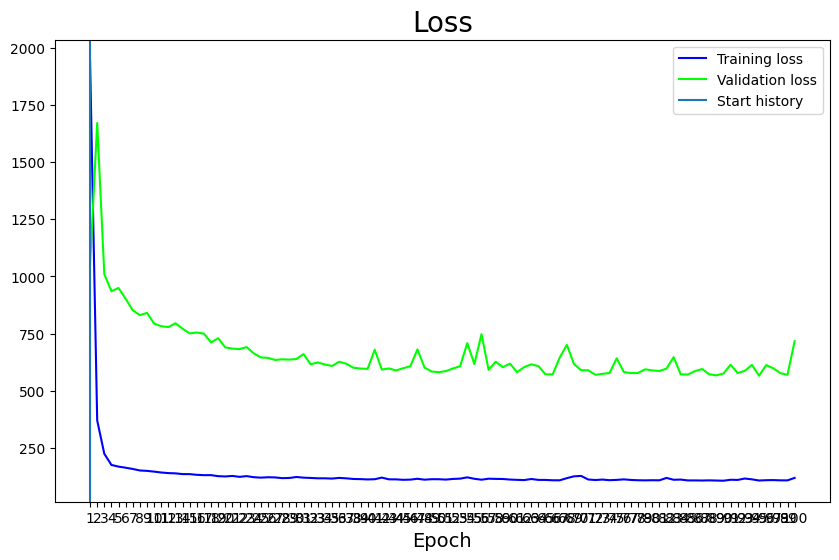

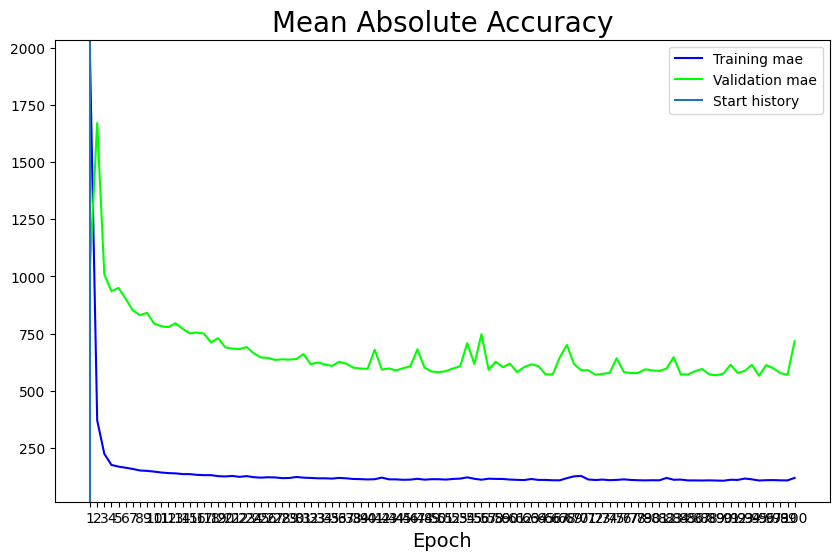

In [41]:
soml.tf.model.plot.plot_history(history=model_1_history)

In [42]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 448us/step - loss: 716.3403 - mae: 716.3403 - mse: 1500610.7500


[716.3402709960938, 716.3402709960938, 1500610.75]

In [43]:
model_1 = soml.tf.model.io.load_model(filepath='./checkpoints/model_1_dense')

In [44]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 445us/step - loss: 569.3180 - mae: 569.3180 - mse: 1166763.1250


[569.3179931640625, 569.3179931640625, 1166763.125]

## Making forecasts with a model (on the test data)

To make "forecasts" on the test dataset (note: these won´t be actual forecasts, they're only psuedo forecasts because actual forecasts are intop the future), let's write a function to:

1. Take in a train model
2. Take in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's predict() method
4. Return the predictions

In [45]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions.

In [46]:
# Make predictions using model_1, 
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 354us/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8828.813, 8754.272, 9022.768, 8766.118, 8697.899, 8695.859,
        8688.895, 8489.795, 8427.532, 8516.433], dtype=float32)>)

In [47]:
test_labels[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [48]:
model_1_result = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_result

{'mae': 569.318,
 'mse': 1166763.1,
 'rmse': 1080.1681,
 'mape': 2.5481882,
 'mase': 1.000134}

In [49]:
naive_result

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

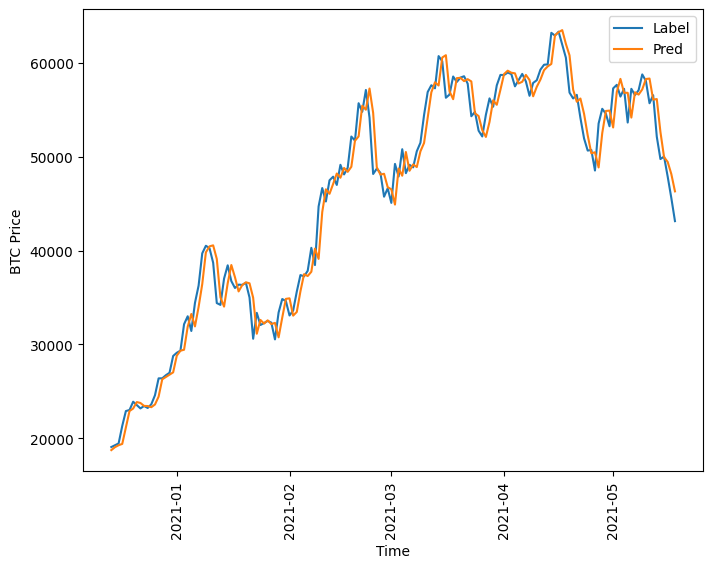

In [50]:
# Letś plot our model 1 predicitons

# The X_test contains the dates for each label
# The test_windows contain a 2 dim array of shape 556, 7
# The test_labels and model_1_preds contain the labels of shape 556, 1
soml.data.timeseries.plot.timeseries(
    x=[X_test[-len(test_windows):], X_test[-len(test_windows):]], 
    y=[tf.squeeze(test_labels), model_1_preds], 
    labels=['Label', 'Pred'], 
    start=400, x_label='Time', y_label='BTC Price'
)

## Model 2: Dense (window = 30, horizon = 1)

In [51]:
WINDOW_SIZE = 30
HORIZON = 1

full_windows_30_1, full_labels_30_1 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [52]:
full_windows_30_1.shape, full_labels_30_1.shape

((2757, 30), (2757, 1))

In [53]:
train_windows_30_1, test_windows_30_1, train_labels_30_1, test_labels_30_1 = make_train_test_splits(full_windows_30_1, full_labels_30_1)
len(train_windows_30_1), len(test_windows_30_1), len(train_labels_30_1), len(test_labels_30_1)

(2205, 552, 2205, 552)

In [54]:
# Set random seed for reproducable results.
tf.random.set_seed(42)

# 1. Construct the model
model_2 = tf.keras.Sequential([
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=HORIZON, activation="linear") # activation = "linear" = "None"
], name="model_2_dense")

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name=model_2.name, 
                                                                           monitor='val_loss',
                                                                           save_weights_only=False)

# 3. Fit the model
model_2_history = model_2.fit(x=train_windows_30_1,
            y=train_labels_30_1,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows_30_1, test_labels_30_1),
            callbacks=[model_checkpoint_callback])

INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_2_dense/model/assets


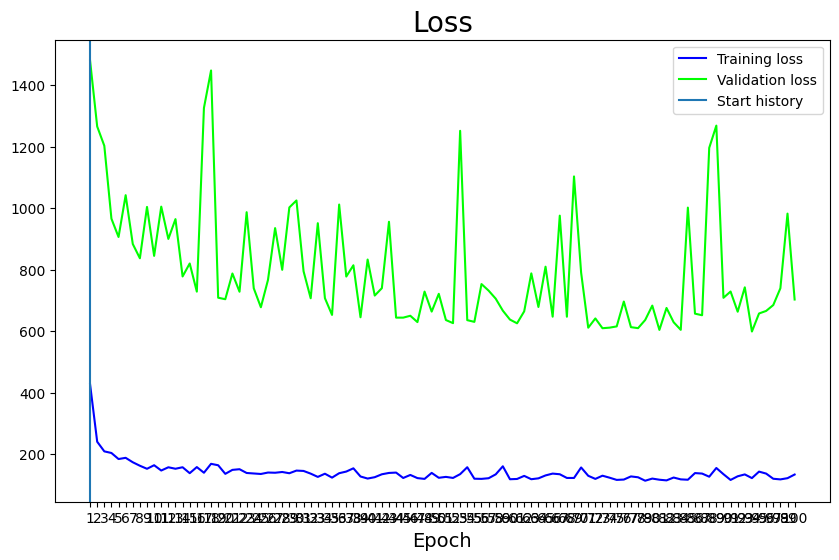

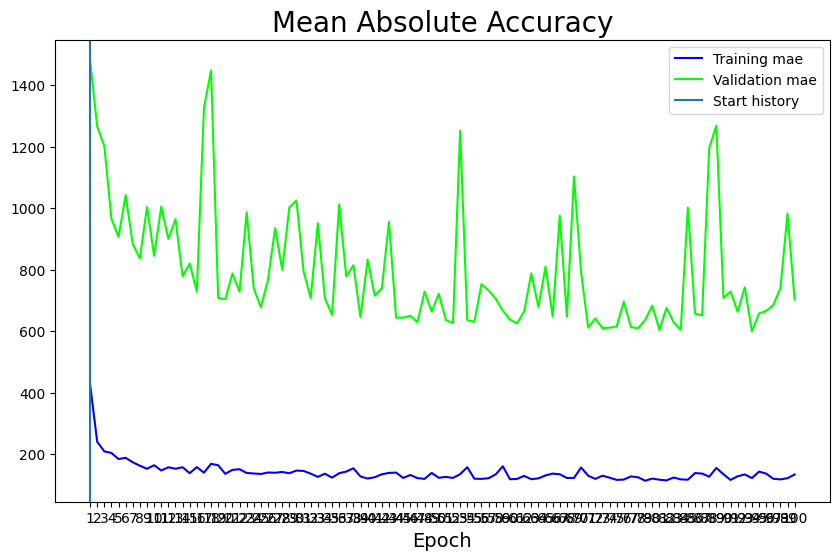

In [55]:
soml.tf.model.plot.plot_history(history=model_2_history)

In [56]:
model_2.evaluate(x=test_windows_30_1, y=test_labels_30_1)

18/18 [==============================] - 0s 431us/step - loss: 702.9935 - mae: 702.9935 - mse: 1566761.2500


[702.9935302734375, 702.9935302734375, 1566761.25]

In [57]:
model_2 = soml.tf.model.io.load_model(filepath='./checkpoints/model_2_dense')

In [58]:
model_2.evaluate(x=test_windows_30_1, y=test_labels_30_1)

18/18 [==============================] - 0s 464us/step - loss: 603.0449 - mae: 603.0449 - mse: 1277321.5000


[603.044921875, 603.044921875, 1277321.5]

In [59]:
model_2_preds = make_preds(model_2, test_windows_30_1)
len(model_2_preds), model_2_preds[:10]

18/18 [==============================] - 0s 382us/step


(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8793.593 , 8759.262 , 8679.877 , 8674.784 , 8525.298 , 8369.098 ,
        8304.588 , 8130.5747, 8232.356 , 7954.245 ], dtype=float32)>)

In [60]:
model_2_result = evaluate_preds(y_true=tf.squeeze(test_labels_30_1), y_pred=model_2_preds)
model_2_result

{'mae': 603.04486,
 'mse': 1277321.5,
 'rmse': 1130.1865,
 'mape': 2.7583387,
 'mase': 1.0541283}

In [61]:
model_1_result

{'mae': 569.318,
 'mse': 1166763.1,
 'rmse': 1080.1681,
 'mape': 2.5481882,
 'mase': 1.000134}

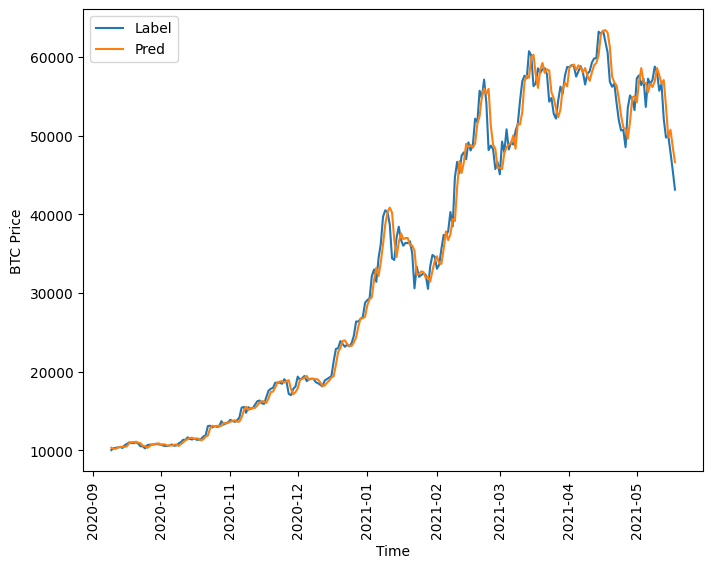

In [62]:
# Letś plot our model 2 predicitons

# The X_test contains the dates for each label
# The test_windows contain a 2 dim array of shape 556, 7
# The test_labels and model_1_preds contain the labels of shape 556, 1
soml.data.timeseries.plot.timeseries(
    x=[X_test[-len(test_windows_30_1):], X_test[-len(test_windows_30_1):]], 
    y=[tf.squeeze(test_labels_30_1), model_2_preds], 
    labels=['Label', 'Pred'], 
    start=300, x_label='Time', y_label='BTC Price'
)

## Model 3: Dense (window = 30, horizon = 7)

In [63]:
WINDOW_SIZE = 30
HORIZON = 7

full_windows_30_7, full_labels_30_7 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [64]:
full_windows_30_7.shape, full_labels_30_7.shape

((2751, 30), (2751, 7))

In [65]:
train_windows_30_7, test_windows_30_7, train_labels_30_7, test_labels_30_7 = make_train_test_splits(full_windows_30_7, full_labels_30_7)
len(train_windows_30_7), len(test_windows_30_7), len(train_labels_30_7), len(test_labels_30_7)

(2200, 551, 2200, 551)

In [66]:
# Set random seed for reproducable results.
tf.random.set_seed(42)

# 1. Construct the model
model_3 = tf.keras.Sequential([
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=HORIZON, activation="linear") # activation = "linear" = "None"
], name="model_3_dense")

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name=model_3.name, 
                                                                           monitor='val_loss',
                                                                           save_weights_only=False)

# 3. Fit the model
model_3_history = model_3.fit(x=train_windows_30_7,
            y=train_labels_30_7,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows_30_7, test_labels_30_7),
            callbacks=[model_checkpoint_callback])

INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_3_dense/model/assets


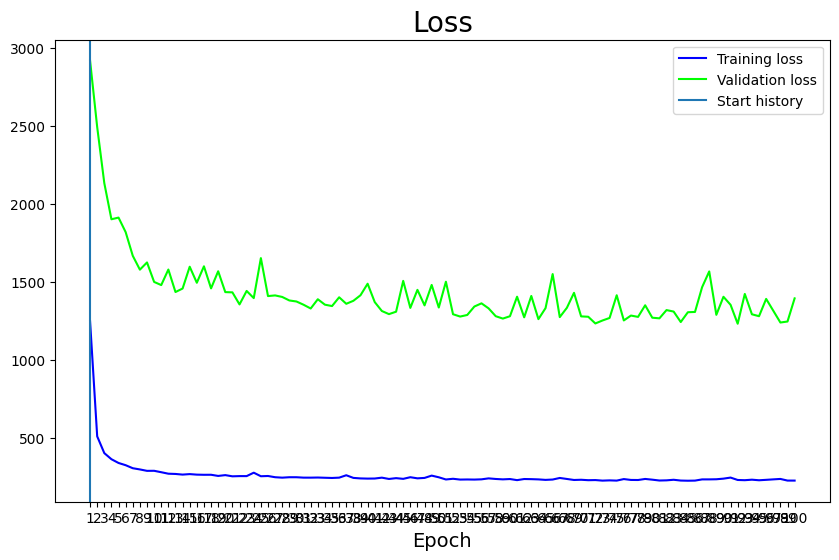

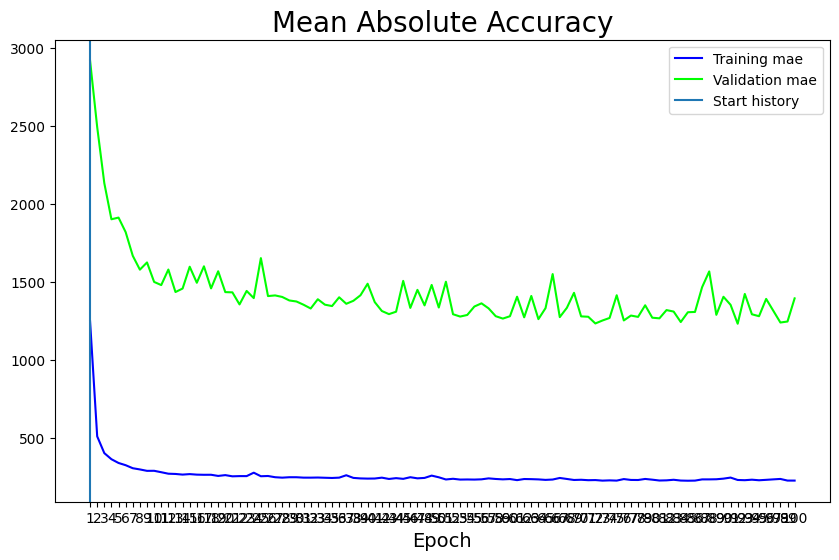

In [67]:
soml.tf.model.plot.plot_history(history=model_3_history)

In [68]:
model_3.evaluate(x=test_windows_30_7, y=test_labels_30_7)

18/18 [==============================] - 0s 421us/step - loss: 1393.7561 - mae: 1393.7561 - mse: 6015320.5000


[1393.756103515625, 1393.756103515625, 6015320.5]

In [69]:
model_3 = soml.tf.model.io.load_model(filepath='./checkpoints/model_3_dense/model')

In [70]:
model_3.evaluate(x=test_windows_30_7, y=test_labels_30_7)

18/18 [==============================] - 0s 490us/step - loss: 1230.9902 - mae: 1230.9902 - mse: 5307695.0000


[1230.990234375, 1230.990234375, 5307695.0]

In [71]:
model_3_preds = make_preds(model_3, test_windows_30_7)
model_3_preds[:5]

18/18 [==============================] - 0s 350us/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9583.15  , 9512.148 , 9348.5   , 9512.3955, 9891.113 , 9638.223 ,
        9653.339 ],
       [9245.697 , 9107.504 , 9035.584 , 9275.662 , 9486.495 , 9356.604 ,
        9414.398 ],
       [8944.795 , 8752.705 , 8926.046 , 9025.15  , 9188.351 , 8978.15  ,
        9334.335 ],
       [9024.583 , 8838.562 , 9152.503 , 9122.876 , 9341.089 , 9084.917 ,
        9497.642 ],
       [9086.075 , 8890.774 , 8998.957 , 8947.434 , 9228.811 , 9055.886 ,
        9209.702 ]], dtype=float32)>

In [72]:
tf.squeeze([[[1], [2], [3], [4]]], axis=0)

<tf.Tensor: shape=(4, 1), dtype=int32, numpy=
array([[1],
       [2],
       [3],
       [4]], dtype=int32)>

In [73]:
model_3_preds.shape, test_labels_30_7.shape

(TensorShape([551, 7]), (551, 7))

In [74]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different size metrics (for longer horizons, we want to reduce metrics to a single scalar)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    
    return {
        'mae': mae.numpy(),
        'mse': mse.numpy(),
        'rmse': rmse,
        'mape': mape.numpy(),
        'mase': mase.numpy()}

In [75]:
model_3_result = evaluate_preds(y_true=tf.squeeze(test_labels_30_7), y_pred=model_3_preds)
model_3_result

{'mae': 1230.9902,
 'mse': 5307695.5,
 'rmse': <tf.Tensor: shape=(), dtype=float32, numpy=1417.488>,
 'mape': 5.652219,
 'mase': 2.190478}

In [76]:
model_2_result

{'mae': 603.04486,
 'mse': 1277321.5,
 'rmse': 1130.1865,
 'mape': 2.7583387,
 'mase': 1.0541283}

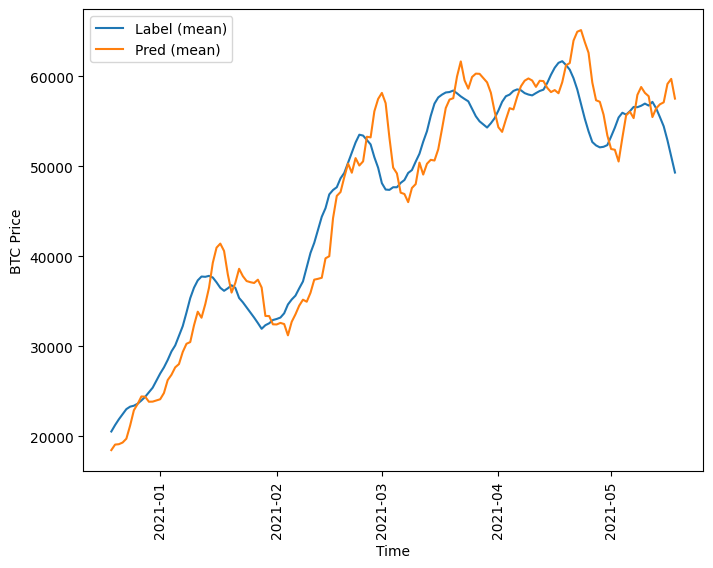

In [77]:
# Letś plot our model 2 predicitons

# The X_test contains the dates for each label
# The test_windows contain a 2 dim array of shape 556, 7
# The test_labels and model_1_preds contain the labels of shape 556, 1

soml.data.timeseries.plot.timeseries(
    x=[X_test[-len(test_windows_30_7):], X_test[-len(test_windows_30_7):]], 
    y=[test_labels_30_7, model_3_preds],
    labels=['Label', 'Pred'], 
    start=400, x_label='Time', y_label='BTC Price'
)

In [78]:
model_1_result

{'mae': 569.318,
 'mse': 1166763.1,
 'rmse': 1080.1681,
 'mape': 2.5481882,
 'mase': 1.000134}

In [79]:
model_2_result

{'mae': 603.04486,
 'mse': 1277321.5,
 'rmse': 1130.1865,
 'mape': 2.7583387,
 'mase': 1.0541283}

In [80]:
model_3_result

{'mae': 1230.9902,
 'mse': 5307695.5,
 'rmse': <tf.Tensor: shape=(), dtype=float32, numpy=1417.488>,
 'mape': 5.652219,
 'mase': 2.190478}

In [81]:
naive_result

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Which of our models is performing the best so far?

So we've trained a few models, now let's compare them and see how they've gone...

<Axes: >

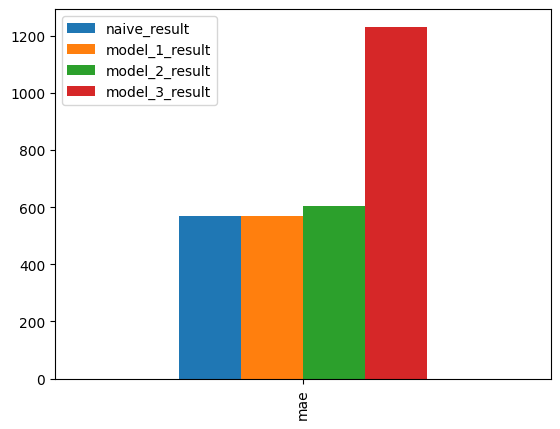

In [82]:
pd.DataFrame(
    {
    'naive_result': naive_result['mae'],
    'model_1_result': model_1_result['mae'], 
    'model_2_result': model_2_result['mae'],
    'model_3_result': model_3_result['mae']
    }, index=['mae']).plot.bar(log=False)

# Note: What is the naive model so good?

You might be wondering, why are the naive results so good? One of the reasons could be due to presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but oftenm fluctuate randomly), a naive model will often get fairly good results.

For more information:

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

## Model 4: Conv1D

In [83]:
HORIZON = 1
WINDOW_SIZE =7

In [84]:
# Create windows data (done before)
len(full_windows), len(full_labels)

(2780, 2780)

In [85]:
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

We need an input shape of: `(batch_size, timesteps, input_dim)`...

However, our data isn´t in that shape yet.

In [86]:
# Check data input shape
train_windows[0].shape # returns (window_size, )

(7,)

In [87]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works.
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [88]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for 'input_dim'.

In [89]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape: {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [90]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    layers.Dense(units=1, activation='linear')
], name='model_4_conv1D')

model_4.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name=model_4.name, 
                                                                           monitor='val_loss',
                                                                           save_weights_only=False)


model_4_history = model_4.fit(x=train_windows, 
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint_callback])

INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_4_conv1D/model/assets


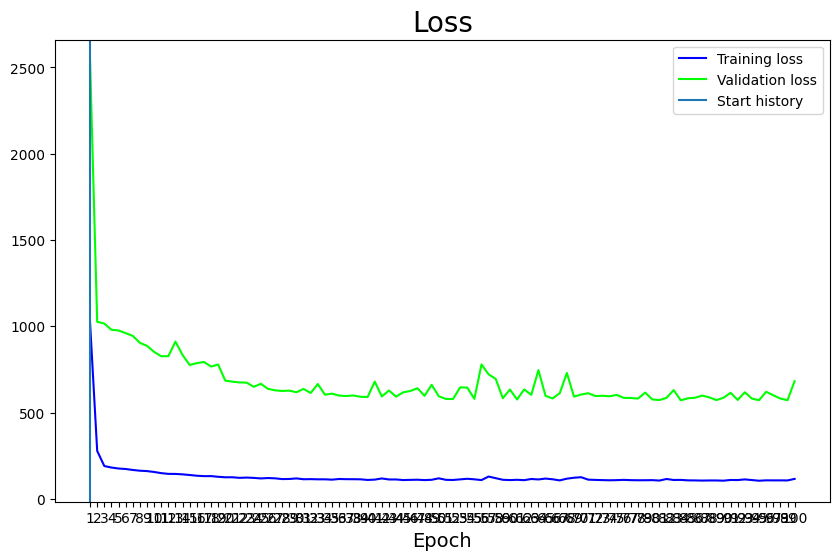

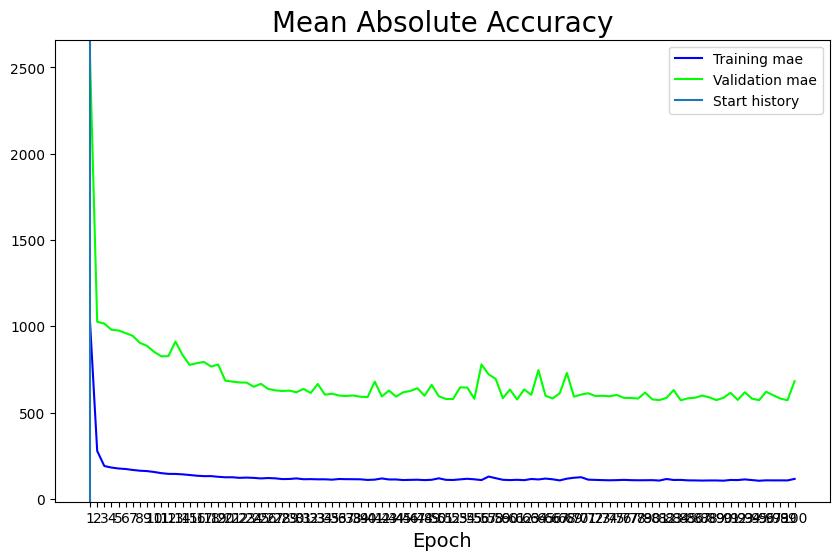

In [91]:
soml.tf.model.plot.plot_history(history=model_4_history)

In [92]:
model_4.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 520us/step - loss: 682.2252 - mae: 682.2252 - mse: 1404406.8750


[682.2251586914062, 682.2251586914062, 1404406.875]

In [93]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
# Load bakc in best performing Conv1D and re-evaluate
model_4 = soml.tf.model.io.load_model(filepath='./checkpoints/model_4_conv1D/model')

In [95]:
model_4.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 557us/step - loss: 571.2571 - mae: 571.2571 - mse: 1182757.1250


[571.257080078125, 571.257080078125, 1182757.125]

In [96]:
# Make predictions
model_4_preds = make_preds(model=model_4, input_data=test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 478us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8875.37 , 8771.749, 9015.444, 8787.907, 8713.658, 8738.519,
       8689.255, 8517.995, 8453.629, 8522.574], dtype=float32)>

In [97]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_4_preds)
model_4_results

{'mae': 571.2571,
 'mse': 1182757.1,
 'rmse': 1087.5464,
 'mape': 2.5626724,
 'mase': 1.0035405}

In [98]:
naive_result

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.
We'll use the same data we created previously.

In [99]:
tf.random.set_seed(42)


inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(units=128,activation='relu', return_sequences=True)(x)
x = layers.LSTM(units=128, activation='relu')(x)
x = layers.Dense(units=32, activation='relu')(x)
ouputs = layers.Dense(units=HORIZON, activation='linear')(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=ouputs, name='model_5_LSTM')


model_5.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name=model_5.name, 
                                                                           monitor='val_loss',
                                                                           save_weights_only=False)


model_5_history = model_5.fit(x=train_windows, 
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint_callback])

INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_5_LSTM/model/assets


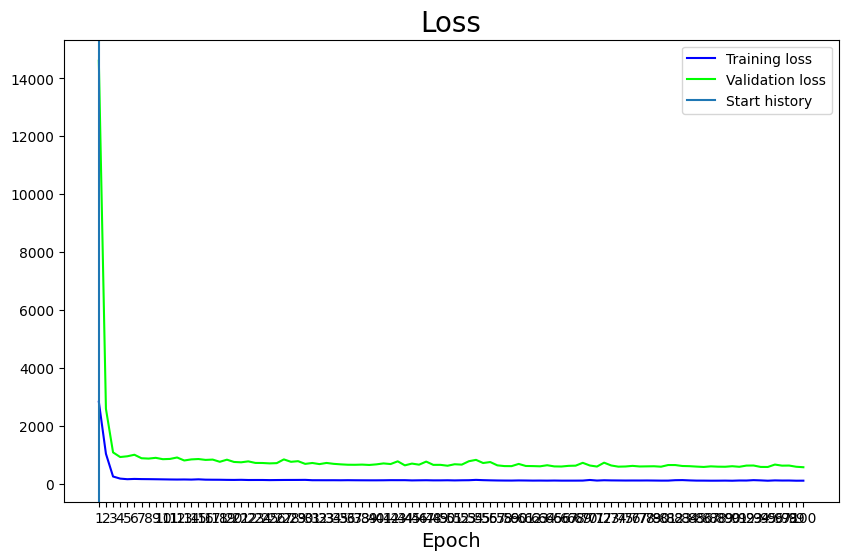

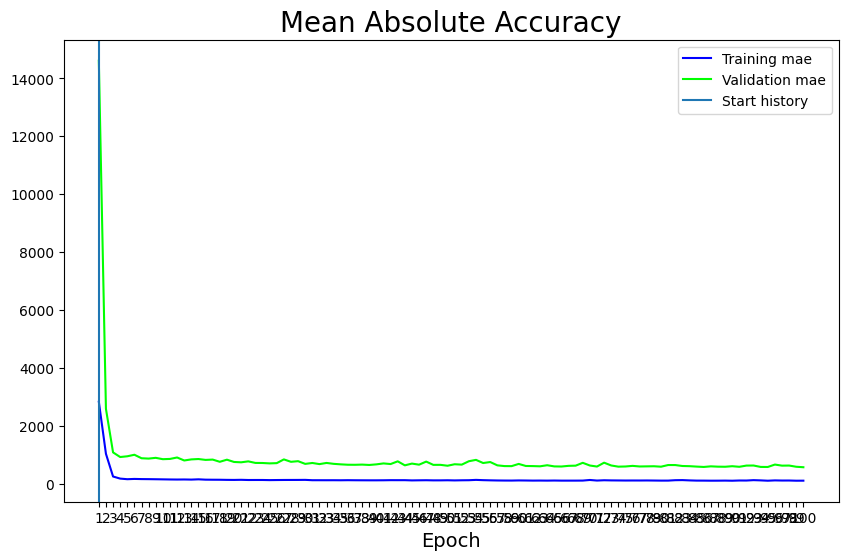

In [100]:
soml.tf.model.plot.plot_history(history=model_5_history)

In [101]:
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 611us/step - loss: 574.7826 - mae: 574.7826 - mse: 1191666.6250


[574.7825927734375, 574.7825927734375, 1191666.625]

In [102]:
model_5 = soml.tf.model.io.load_model(filepath='./checkpoints/model_5_LSTM/model')
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 715us/step - loss: 574.7826 - mae: 574.7826 - mse: 1191666.6250


[574.7825927734375, 574.7825927734375, 1191666.625]

In [103]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 606us/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8891.863, 8788.173, 8960.925, 8774.576, 8781.423], dtype=float32)>

In [104]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results, model_1_result

({'mae': 574.7826,
  'mse': 1191666.9,
  'rmse': 1091.635,
  'mape': 2.5893004,
  'mase': 1.0097338},
 {'mae': 569.318,
  'mse': 1166763.1,
  'rmse': 1080.1681,
  'mape': 2.5481882,
  'mase': 1.000134})

**Note: Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.**

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is wheter or not Daniel Bourke tweeted on that day.

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en-nz/learn-cryptocurrencies/bitcoin-halving

In [105]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [106]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 03-01-2009 - this block reward isn't in our dataset (dataset starts later)
block_reward_2 = 25 # 08-11-2012
block_reward_3 = 12.5 # 09-07-2016
block_reward_4 = 6.25 # 18-05-2020

# Block reward dates
block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-18')



In [107]:
bitcoin_prices_block = bitcoin_prices.copy()

bitcoin_prices_block['block_reward'] = 0
bitcoin_prices_block.loc[(bitcoin_prices_block.index >= block_reward_2_datetime) & (bitcoin_prices_block.index < block_reward_3_datetime), 'block_reward'] = block_reward_2
bitcoin_prices_block.loc[(bitcoin_prices_block.index >= block_reward_3_datetime) & (bitcoin_prices_block.index < block_reward_4_datetime), 'block_reward'] = block_reward_3
bitcoin_prices_block.loc[(bitcoin_prices_block.index >= block_reward_4_datetime), 'block_reward'] = block_reward_4

<Axes: xlabel='Date'>

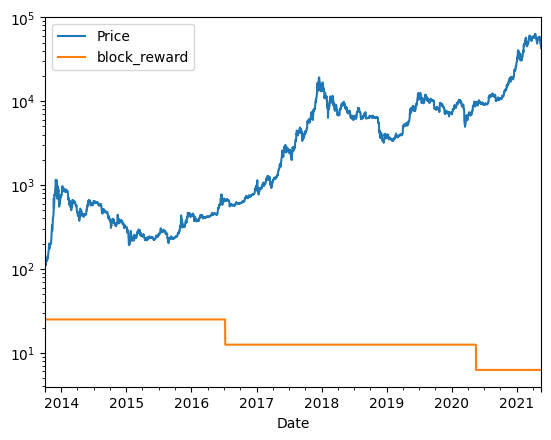

In [108]:
bitcoin_prices_block.plot(logy=True)

<Axes: xlabel='Date'>

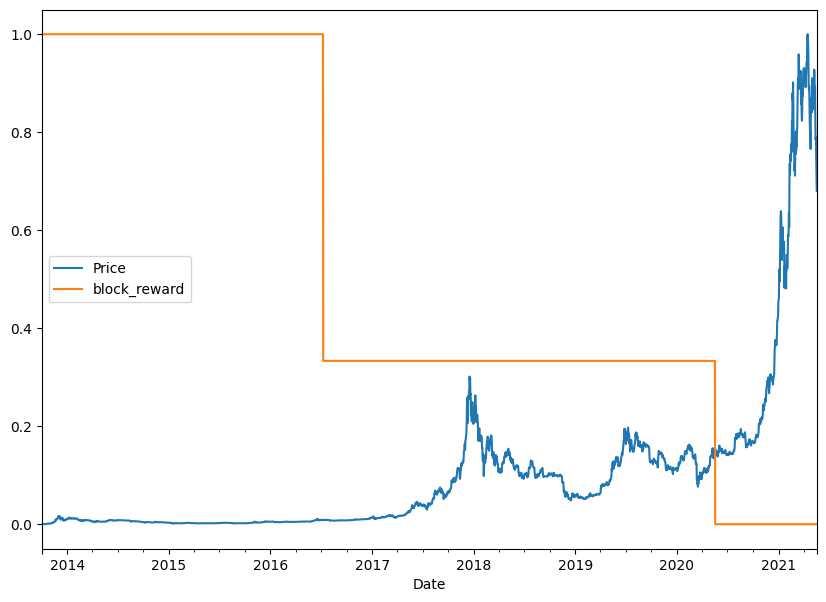

In [109]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Price', 'block_reward']]), columns=bitcoin_prices_block.columns, index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7))

## Making a windowed dataset with pandas

Previously we've turned our univariate time serereis into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html

In [110]:
# Setup dataset hyperparameters
HORIZON=1
WINDOW_SIZE=7

In [111]:
# Make a copy of the Bitcoin historical data with bloc reward.
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods=i+1)
bitcoin_prices_windowed.head(20)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25.0,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25.0,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25.0,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25.0,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [112]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [113]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [114]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [115]:
# Set random seed for reproducable results.
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=HORIZON, activation="linear")
], name="model_6_dense_multivariate")

# 2. Compile the model
model_6.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name=model_6.name, 
                                                                           monitor='val_loss',
                                                                           save_weights_only=False, verbose=0)

# 3. Fit the model
model_6_history = model_6.fit(x=X_train,
            y=y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[model_checkpoint_callback])

INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6_dense_multivariate/model/assets


In [116]:
# Evaluate multivariate model
model_6.evaluate(x=X_test, y=y_test)

18/18 [==============================] - 0s 412us/step - loss: 709.4531 - mae: 709.4531 - mse: 1486119.0000


[709.453125, 709.453125, 1486119.0]

In [117]:
# Load in and evaluate best performing model
model_6 = soml.tf.model.io.load_model(filepath='./checkpoints/model_6_dense_multivariate/model')
model_6.evaluate(x=X_test, y=y_test)

18/18 [==============================] - 0s 480us/step - loss: 566.1960 - mae: 566.1960 - mse: 1154132.7500


[566.196044921875, 566.196044921875, 1154132.75]

In [118]:
# Make predictions with multivariate model
model_6_preds = make_preds(model_6, X_test)
model_6_preds[:5]

18/18 [==============================] - 0s 353us/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8847.082, 8781.305, 9066.258, 8765.979, 8747.09 ], dtype=float32)>

In [119]:
# Evaluate prediction to get eval metrics
model_6_results = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_6_preds)
model_6_results, model_1_result

({'mae': 566.1961,
  'mse': 1154132.8,
  'rmse': 1074.3057,
  'mape': 2.5164673,
  'mase': 0.9946497},
 {'mae': 569.318,
  'mse': 1166763.1,
  'rmse': 1080.1681,
  'mape': 2.5481882,
  'mase': 1.000134})

For a challenge on different ways to potentially improve the multivariate tiem sereis mode, see the reference here:

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

## Same model as model 6 but with additional Dense layer.

In [120]:
# Set random seed for reproducable results.
tf.random.set_seed(42)

# Make multivariate time series model
model_6a = tf.keras.Sequential([
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=HORIZON, activation="linear")
], name="model_6a_dense_multivariate")

# 2. Compile the model
model_6a.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name=model_6a.name, 
                                                                           monitor='val_loss',
                                                                           save_weights_only=False, verbose=0)

# 3. Fit the model
model_6a_history = model_6a.fit(x=X_train,
            y=y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[model_checkpoint_callback])

INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6a_dense_multivariate/model/assets


In [121]:
# Load in and evaluate best performing model
model_6 = soml.tf.model.io.load_model(filepath='./checkpoints/model_6_dense_multivariate/model')
model_6.evaluate(x=X_test, y=y_test)

18/18 [==============================] - 0s 434us/step - loss: 566.1960 - mae: 566.1960 - mse: 1154132.7500


[566.196044921875, 566.196044921875, 1154132.75]

In [122]:
model_6a.summary()

Model: "model_6a_dense_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 128)               1152      
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9473 (37.00 KB)
Trainable params: 9473 (37.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Same model as model 6 but with two concatenated models

In [130]:
tf.random.set_seed(42)

input_price = layers.Input(shape=(7,))
x = layers.Dense(units=128, activation='relu')(input_price)
output_price = layers.Dense(units=64, activation='relu')(x)
model_6b_1 = tf.keras.Model(inputs=input_price, outputs=output_price, name='price_model')

input_reward = layers.Input(shape=(1,))
output_reward = layers.Dense(units=32, activation='relu')(input_reward)
model_6b_2 = tf.keras.Model(inputs=input_reward, outputs=output_reward, name='reward_model')

x = layers.Concatenate()([model_6b_1.output, model_6b_2.output])
output = layers.Dense(units=HORIZON)(x)

model_6b = tf.keras.Model(inputs=[model_6b_1.input, model_6b_2.input], outputs=output, name='model_6b_multimodel')
model_6b.summary()

Model: "model_6b_multimodel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 dense_17 (Dense)            (None, 128)                  1024      ['input_4[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_18 (Dense)            (None, 64)                   8256      ['dense_17[0][0]']            
                                                                                

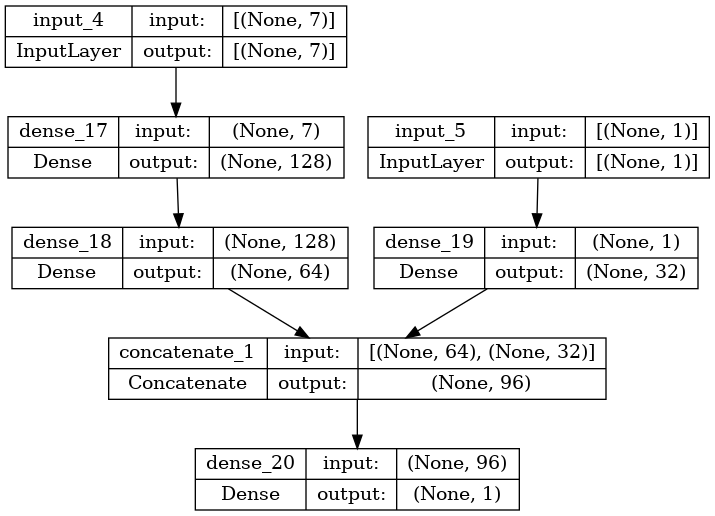

In [131]:
tf.keras.utils.plot_model(model_6b, show_layer_names=True, show_shapes=True)

In [132]:
# 2. Compile the model
model_6b.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name=model_6b.name, 
                                                                           monitor='val_loss',
                                                                           save_weights_only=False, 
                                                                           verbose=0)

# 3. Fit the model
model_6b_history = model_6b.fit(x=[X_train.iloc[:,1:], X_train.iloc[:,0]],
            y=y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=([X_test.iloc[:,1:], X_test.iloc[:,0]], y_test),
            callbacks=[model_checkpoint_callback])

INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


INFO:tensorflow:Assets written to: ./checkpoints/model_6b_multimodel/model/assets


In [133]:
# Load in and evaluate best performing model
model_6b = soml.tf.model.io.load_model(filepath='./checkpoints/model_6b_multimodel/model')
model_6b.evaluate(x=[X_test.iloc[:,1:], X_test.iloc[:,0]], y=y_test)

18/18 [==============================] - 0s 480us/step - loss: 566.1506 - mae: 566.1506 - mse: 1150866.5000


[566.1505737304688, 566.1505737304688, 1150866.5]

In [134]:
# Make predictions with multivariate model
model_6b_preds = make_preds(model_6b, [X_test.iloc[:,1:], X_test.iloc[:,0]])
model_6b_preds[:5]

18/18 [==============================] - 0s 409us/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8802.115, 8769.293, 9043.46 , 8754.412, 8750.204], dtype=float32)>

In [135]:
# Evaluate prediction to get eval metrics
model_6b_results = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_6b_preds)
model_6b_results, model_1_result

({'mae': 566.1505,
  'mse': 1150866.6,
  'rmse': 1072.7845,
  'mape': 2.5497794,
  'mase': 0.99456966},
 {'mae': 569.318,
  'mse': 1166763.1,
  'rmse': 1080.1681,
  'mape': 2.5481882,
  'mase': 1.000134})

In [136]:
naive_result

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}